## Problem Statement 

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, We can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, We need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, We will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, We can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

We need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF

import yellowbrick.classifier
from yellowbrick.classifier import ROCAUC

import itertools

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split


In [2]:
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", 25)

# Data Reading/Data Understanding



In [3]:
#Importing the data
import pandas as pd
data = pd.read_json('complaints.json')
data.head()

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,3211475,0,"{'tags': None, 'zip_code': '90301', 'complaint..."
1,complaint-public-v2,complaint,3229299,0,"{'tags': 'Servicemember', 'zip_code': '319XX',..."
2,complaint-public-v2,complaint,3199379,0,"{'tags': None, 'zip_code': '77069', 'complaint..."
3,complaint-public-v2,complaint,2673060,0,"{'tags': None, 'zip_code': '48066', 'complaint..."
4,complaint-public-v2,complaint,3203545,0,"{'tags': None, 'zip_code': '10473', 'complaint..."


In [4]:
# Converting the data into well formatted DataFrame
#Creating columns from _source.
data_1=pd.Series.to_dict(data['_source'])
data_2=pd.DataFrame(data_1)
data_3=data_2.T
data_4=data.drop(['_source'],axis=1)
df=pd.concat([data_4,data_3],axis=1)
df.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Inspect the dataframe to understand the given data.


In [5]:
#Checking the info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   _index                     78313 non-null  object
 1   _type                      78313 non-null  object
 2   _id                        78313 non-null  int64 
 3   _score                     78313 non-null  int64 
 4   tags                       10900 non-null  object
 5   zip_code                   71556 non-null  object
 6   complaint_id               78313 non-null  object
 7   issue                      78313 non-null  object
 8   date_received              78313 non-null  object
 9   state                      76322 non-null  object
 10  consumer_disputed          78313 non-null  object
 11  product                    78313 non-null  object
 12  company_response           78313 non-null  object
 13  company                    78313 non-null  object
 14  submit

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
#Checking the statistics 
df.describe()

,_id,_score
count,7.831300e+04,78313.0
mean,2.094270e+06,0.0
std,1.277635e+06,0.0
min,4.100000e+01,0.0
25%,9.137850e+05,0.0
50%,2.216370e+06,0.0
75%,3.165904e+06,0.0
max,4.366257e+06,0.0


In [8]:
#checking the shape of the dataset
print('Shape of the dataset',df.shape)

Shape of the dataset (78313, 22)


In [9]:
#Checking the size of the dataset
print('Total elements in the dataset',df.size)


Total elements in the dataset 1722886


In [10]:
#Checking the length of the dataset

print('Length of the data set',len(df))

Length of the data set 78313


In [11]:
#Checking the presence of any duplicated rows.
print('Total number of duplicate:',round(df[df.duplicated()== 'True'].sum().sum()))

Total number of duplicate: 0


In [12]:
#Presence of the null values
Null_df=pd.DataFrame(df.isnull().sum(),columns=['Total_null_value'])
Null_df

,Total_null_value
_index,0
_type,0
_id,0
_score,0
tags,67413
...,...
sub_product,10571
timely,0
complaint_what_happened,0
sub_issue,46297


# Data preparation/Cleaning

In [13]:


# get the old columns names
old_columns = list(df)
# get the list of new column name
new_col_list =['index', 'type', 'id', 'score']
# rename the columns inplate
df.rename(columns={old_columns[idx]: name for  (idx, name) in enumerate(new_col_list)}, inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
#Create a Copy for Exploratory Data Analysis
df_explore = df.copy(deep=True)
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   index                      78313 non-null  object
 1   type                       78313 non-null  object
 2   id                         78313 non-null  int64 
 3   score                      78313 non-null  int64 
 4   tags                       10900 non-null  object
 5   zip_code                   71556 non-null  object
 6   complaint_id               78313 non-null  object
 7   issue                      78313 non-null  object
 8   date_received              78313 non-null  object
 9   state                      76322 non-null  object
 10  consumer_disputed          78313 non-null  object
 11  product                    78313 non-null  object
 12  company_response           78313 non-null  object
 13  company                    78313 non-null  object
 14  submit

In [15]:
#Assign nan in place of blanks in the complaints column
df_explore['complaint_what_happened'] = np.where(df_explore['complaint_what_happened'] =='', np.nan, df_explore['complaint_what_happened'])
df_explore['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [16]:
row_new = df_explore['complaint_what_happened'].isna().sum()
ratio_clean = round((row_new/len(df_explore))*100,2)
print(row_new,'rows has been cleaned from the original',len(df_explore),'rows','that is',ratio_clean,'% of the dataset')

57241 rows has been cleaned from the original 78313 rows that is 73.09 % of the dataset


In [17]:
#Remove all rows where complaints column is nan
df_explore= df_explore[~df_explore.complaint_what_happened.isna()]
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   index                      21072 non-null  object
 1   type                       21072 non-null  object
 2   id                         21072 non-null  int64 
 3   score                      21072 non-null  int64 
 4   tags                       3816 non-null   object
 5   zip_code                   16427 non-null  object
 6   complaint_id               21072 non-null  object
 7   issue                      21072 non-null  object
 8   date_received              21072 non-null  object
 9   state                      20929 non-null  object
 10  consumer_disputed          21072 non-null  object
 11  product                    21072 non-null  object
 12  company_response           21072 non-null  object
 13  company                    21072 non-null  object
 14  submit

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [18]:
#Lets first find patterns which we need to remove

Complaints_brackets = df_explore[df_explore.complaint_what_happened.str.contains('\[\s*\w*\s*\]')]
print('Number of complaints with brackets:',len(Complaints_brackets))

Number of complaints with brackets: 87


In [19]:
brackets = df_explore[df_explore.complaint_what_happened.str.contains('\S*\d\S*')]
print("Number of complaints with words having numbers ",len(brackets))

Number of complaints with words having numbers  16494


In [20]:
##  function  to convert to lower case,Clean the text and remove all the unnecessary elements.
def mani_text(string_text):
   string_text = string_text.lower()
   string_text = re.sub("\[\s*\w*\s*\]", "", string_text)
   string_text = string_text.translate(str.maketrans('', '', string.punctuation))
   string_text = re.sub("\S*\d\S*", "", string_text)

   return string_text

df_explore.complaint_what_happened = pd.DataFrame(df_explore.complaint_what_happened.apply(lambda x: mani_text(x)))  

In [21]:
pd.set_option('display.max_columns', 30)
df_explore.head(10)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided
15,complaint-public-v2,complaint,3209411,0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-11T12:00:00-05:00,None,Credit reporting,Yes,can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided
17,complaint-public-v2,complaint,3331023,0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-06T12:00:00-05:00,None,Checking account,Yes,with out notice jp morgan chase restricted my ...,Funds not received from closed account,Consent provided
20,complaint-public-v2,complaint,3352857,0,None,207XX,3352857,Struggling to pay your loan,2019-08-24T12:00:00-05:00,MD,N/A,Vehicle loan or lease,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-24T12:00:00-05:00,None,Loan,Yes,during the summer months i experience a declin...,Denied request to lower payments,Consent provided
21,complaint-public-v2,complaint,3226110,0,Servicemember,846XX,3226110,Fraud or scam,2019-04-29T12:00:00-05:00,UT,N/A,"Money transfer, virtual currency, or money ser...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-29T12:00:00-05:00,None,Domestic (US) money transfer,Yes,on xxxx i made a payment to an online retail...,None,Consent provided
23,complaint-public-v2,complaint,3237765,0,None,330XX,3237765,Incorrect information on your report,2019-05-09T12:00:00-05:00,FL,N/A,Credit card or prepaid card,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-05-09T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i have a chase credit card which is incorrectl...,Account information incorrect,Consent provided


# Data Preprocessing/Visualisation/Cleaning

In [22]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser','ner',"tok2vec"])
nlp.pipe_names

['tagger', 'attribute_ruler', 'lemmatizer']

In [23]:
#Functions  for lemmatize and post tag
def lemmatize_pos(entity):
    lemma_doc = " ".join([i.lemma_ for i in entity])
    pos_doc = " ".join([i.text for i in entity if i.pos_ == 'NOUN']) 
    return lemma_doc, pos_doc

def spacy_lemmatizer_pos(text):
    return [lemmatize_pos(entity) for entity in nlp.pipe(text, batch_size=50)]
    
df_explore['lemmatized_complaints'],  df_explore['Postags_complaints'] = zip(*spacy_lemmatizer_pos(df_explore['complaint_what_happened']))

In [24]:
#Create a dataframe('df_new') that will have only the complaints and the lemmatized complaints 
df_complaints_lemma_postags = df_explore[['complaint_what_happened','Postags_complaints', 'lemmatized_complaints']].copy()

#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_complaints_lemma_postags.head()

,complaint_what_happened,Postags_complaints,lemmatized_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...
10,chase card was reported on however fraudulent...,chase card was reported on however fraudulent ...,chase card was reported on however fraudulen...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx tick...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it ...


## Exploratory data analysis 

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
*   Plotting the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




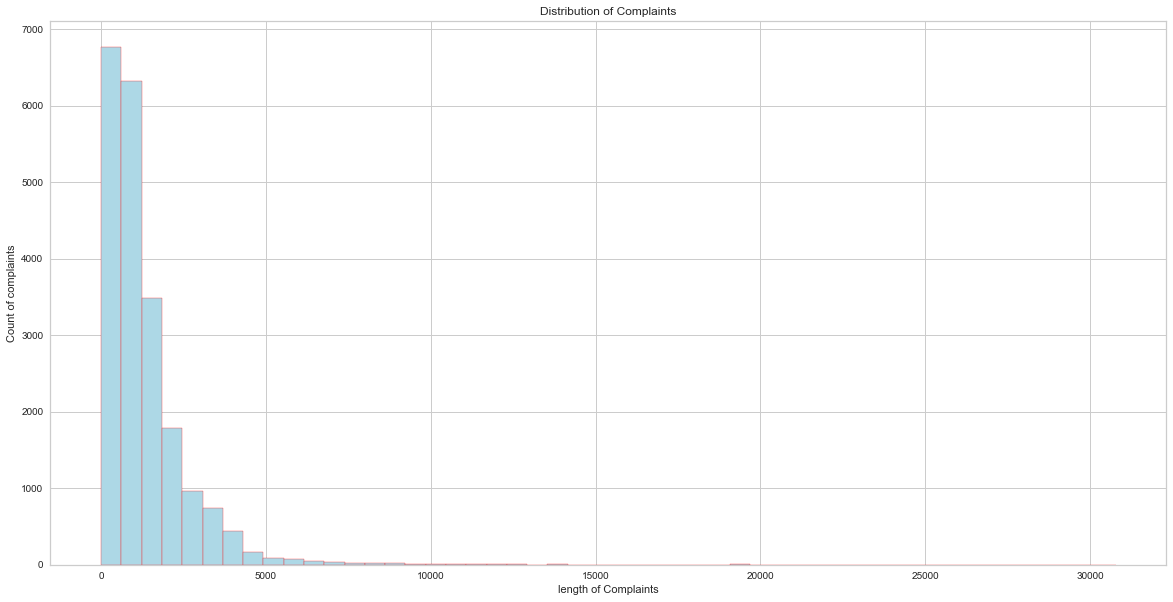

In [25]:
#  Plot to visualize the data according to the 'Complaint' character length
df_complaints_lemma_postags['complaint_len'] = df_complaints_lemma_postags['complaint_what_happened'].astype(str).apply(len)

plt.figure(figsize=(20,10))
df_complaints_lemma_postags['complaint_len'].plot.hist(bins=50, title='Distribution of Complaints',color = "lightblue", ec="red")
plt.xlabel('length of Complaints')
plt.ylabel('Count of complaints')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

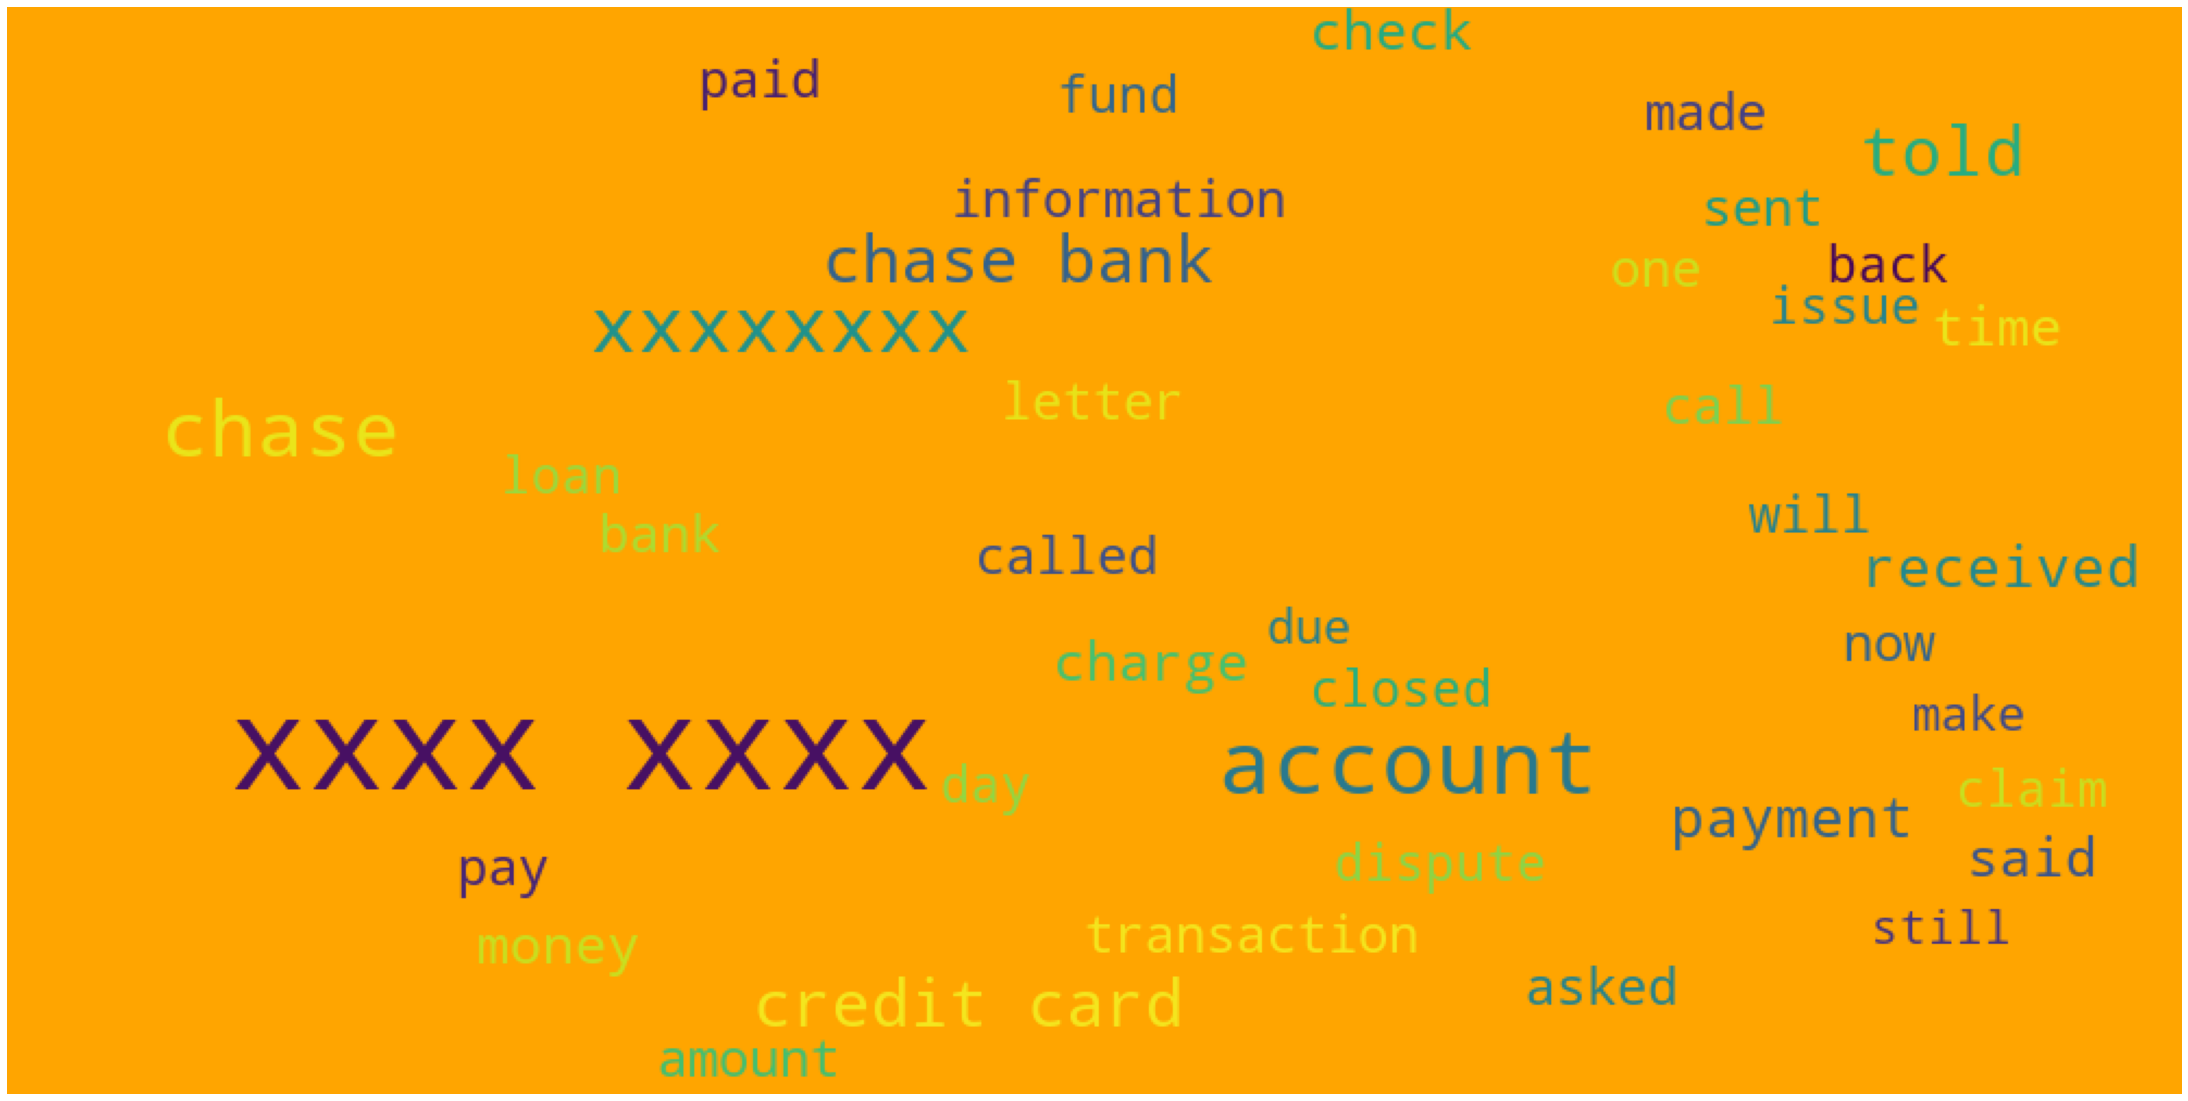

In [26]:
#Plotting a word cloud find the top 40 words by frequency among all the articles after processing the text
Cloud_words_40 = WordCloud( width = 1000, height = 500,max_words = 40,
                      colormap = 'viridis',background_color = 'orange',
                      max_font_size = 60, random_state = 0,prefer_horizontal=1)
Cloud_words_40.generate(" ".join(df_complaints_lemma_postags['complaint_what_happened']))
plt.figure(figsize = (40,20))
plt.imshow(Cloud_words_40)
plt.axis("off")
plt.show()



In [27]:
#Removing -PRON- from the text corpus
df_complaints_lemma_postags['clean_complaints'] = df_complaints_lemma_postags['lemmatized_complaints'].str.replace('-PRON-', '')

In [28]:
#All -PRON- texts has been removed 
df_complaints_lemma_postags.head()

,complaint_what_happened,Postags_complaints,lemmatized_complaints,complaint_len,clean_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,475,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...,337,i upgraded my xxxx xxxx card in and was told...
10,chase card was reported on however fraudulent...,chase card was reported on however fraudulent ...,chase card was reported on however fraudulen...,210,chase card was reported on however fraudulen...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx tick...,1433,on while trying to book a xxxx xxxx tick...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it ...,456,my grand son give me check for i deposit it ...


### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
#Function to return the top 'n' words from corpus for a given 'n_gram_range'
def N_Top_ngram( body, n_gram_value,num):
    vec = CountVectorizer(ngram_range=(n_gram_value, n_gram_value), stop_words='english').fit(body)
    bag_of_words = vec.transform(body)
    sum_words = bag_of_words.sum(axis=0) 
    frequency_word = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    frequency_word_sorted =sorted(frequency_word, key = lambda x: x[1], reverse=True)
    return frequency_word_sorted[:num]

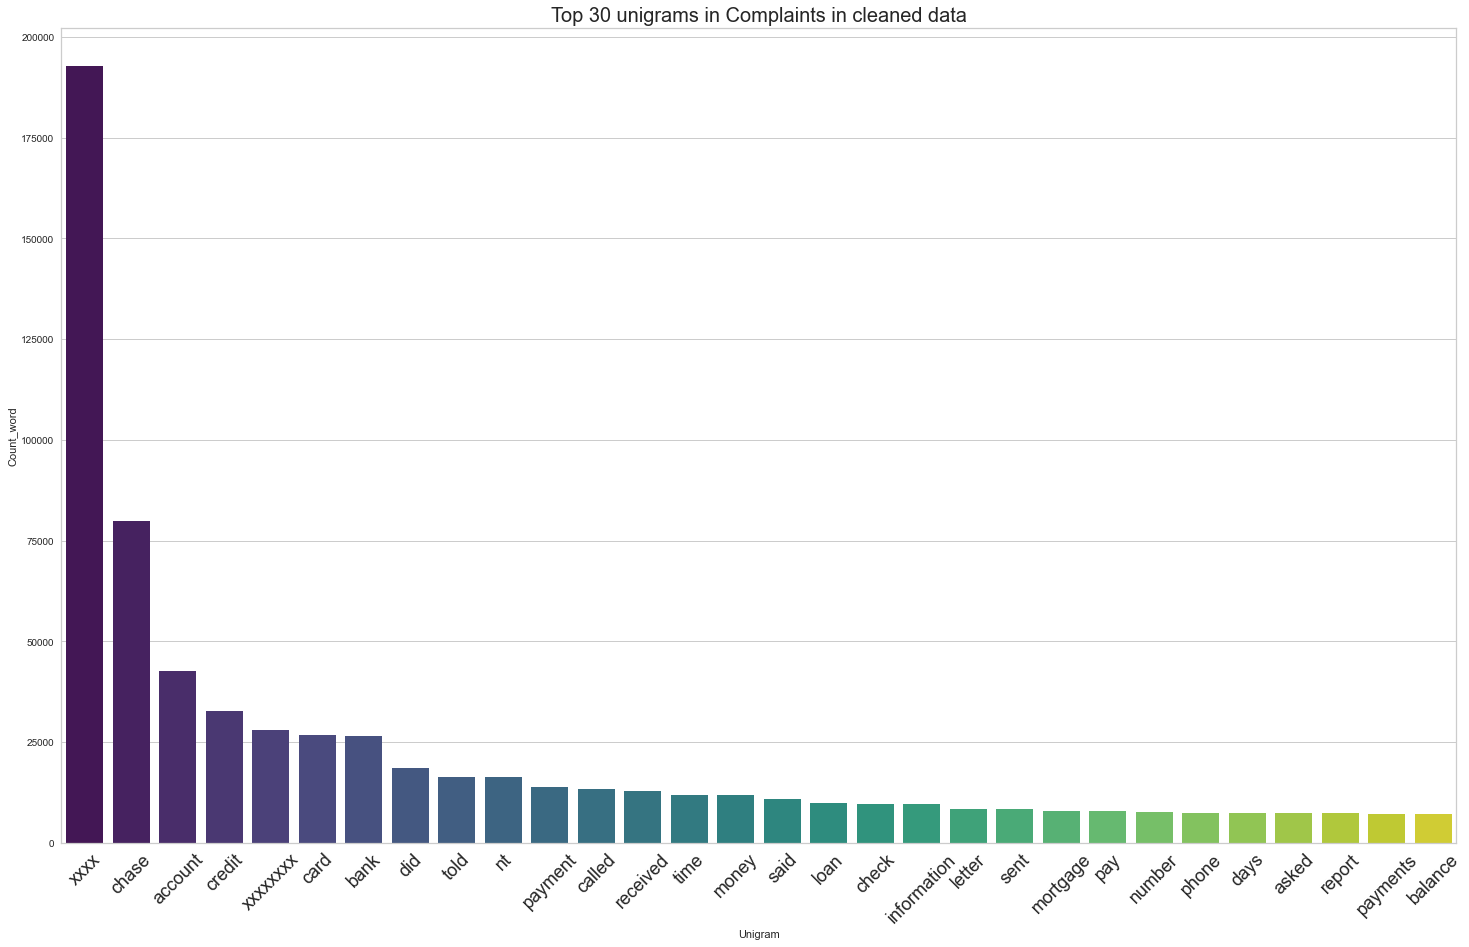

In [30]:
#Plotting  the top 30 unigram frequency among the complaints in the cleaned datafram. 
common_words = N_Top_ngram(df_complaints_lemma_postags['clean_complaints'], 1, 30)
df_ngram_count = pd.DataFrame(common_words, columns = ['Unigram' , 'Count_word'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df_ngram_count['Unigram'], y=df_ngram_count['Count_word'],palette="viridis")
fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 18)
plt.title('Top 30 unigrams in Complaints in cleaned data',fontsize=20)
plt.show()

In [31]:
#View the top 10 words in the unigram frequency
df_ngram_count.head(10)

,Unigram,Count_word
0,xxxx,192695
1,chase,79861
2,account,42591
3,credit,32677
4,xxxxxxxx,27927
5,card,26847
6,bank,26651
7,did,18481
8,told,16380
9,nt,16289


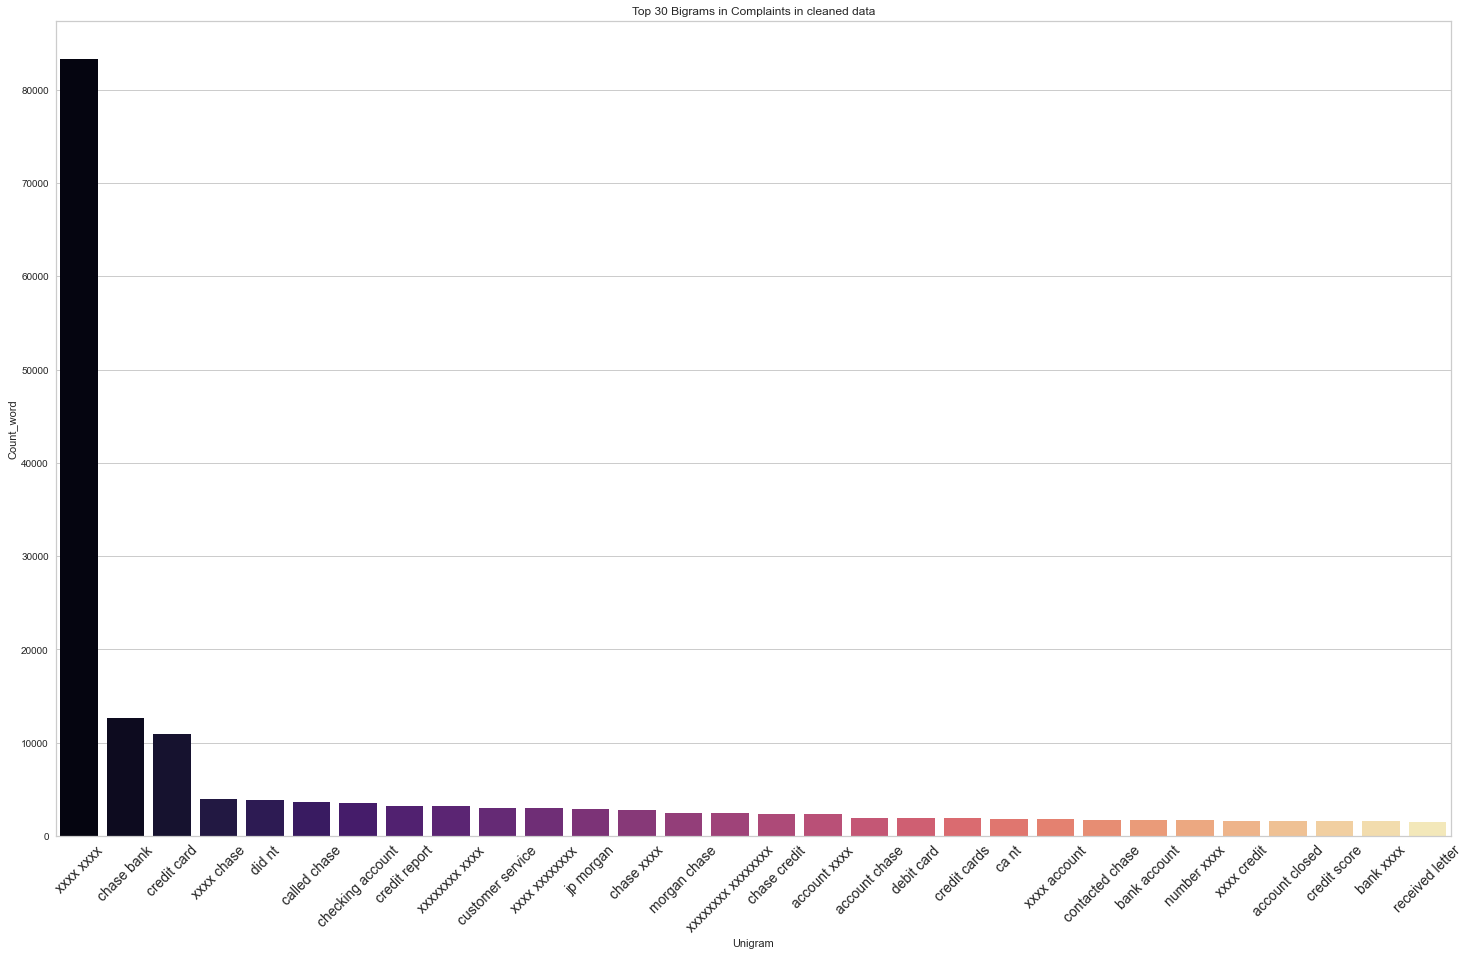

In [32]:
 
#Plotting  the top 30 Bigram frequency among the complaints in the cleaned datafram. 
common_words = N_Top_ngram(df_complaints_lemma_postags['clean_complaints'], 2, 30)
df_Bigram_count = pd.DataFrame(common_words, columns = ['Unigram' , 'Count_word'])
plt.figure(figsize=[25,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df_Bigram_count['Unigram'], y=df_Bigram_count['Count_word'],palette="magma")
fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 14)
plt.title('Top 30 Bigrams in Complaints in cleaned data')
plt.show()

In [33]:
#Print the top 10 words in the bigram frequency
df_Bigram_count.head(10)

,Unigram,Count_word
0,xxxx xxxx,83247
1,chase bank,12609
2,credit card,10905
3,xxxx chase,3945
4,did nt,3837
5,called chase,3688
6,checking account,3551
7,credit report,3237
8,xxxxxxxx xxxx,3206
9,customer service,3014


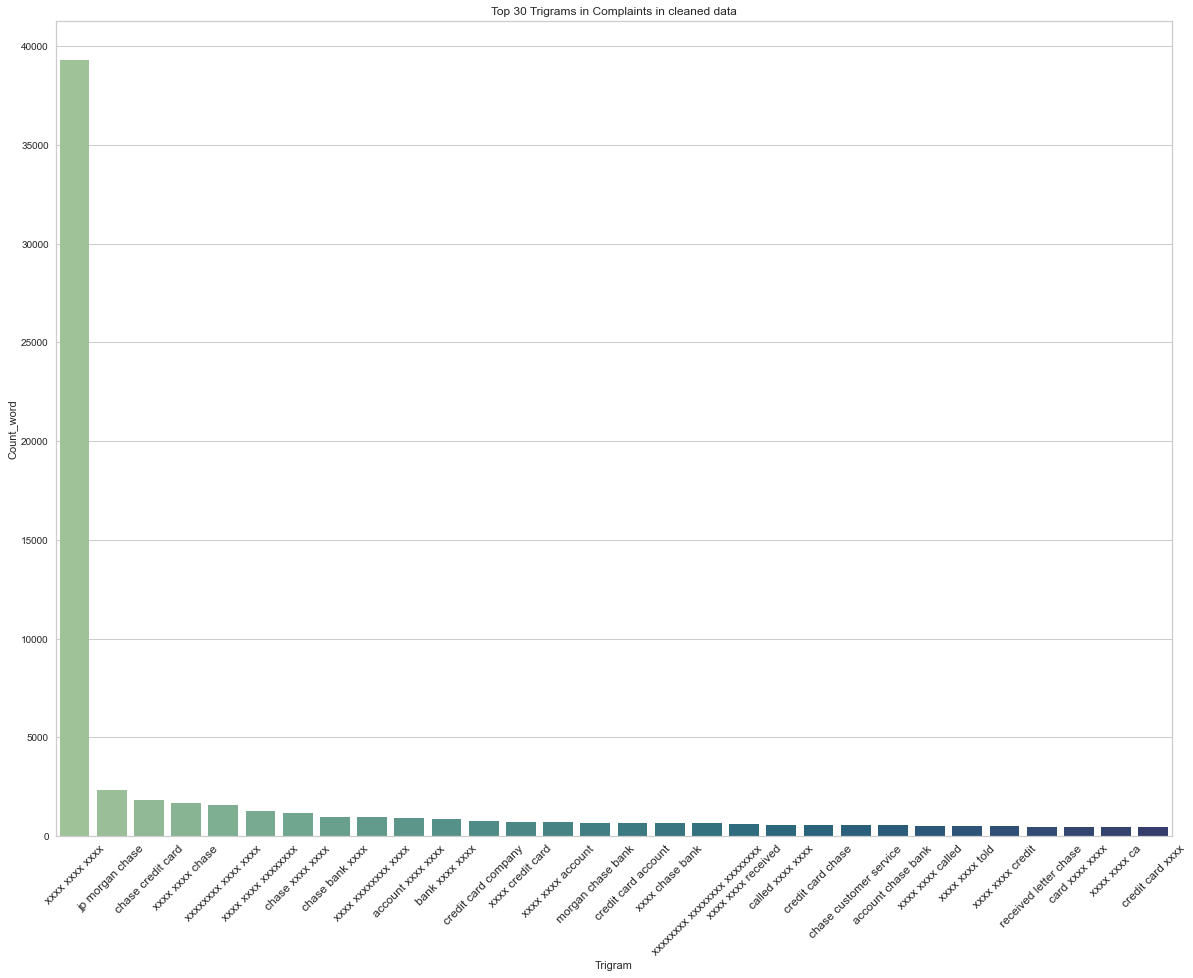

In [34]:
#Plotting the top 30 trigram frequency among the complaints in the cleaned datafram.  
common_words = N_Top_ngram(df_complaints_lemma_postags['clean_complaints'], 3, 30)
df_Trigram_count = pd.DataFrame(common_words, columns = ['Trigram' , 'Count_word'])
plt.figure(figsize=[20,15])
plt.xticks(rotation=45)
fig = sns.barplot(x=df_Trigram_count['Trigram'], y=df_Trigram_count['Count_word'],palette="crest")
fig.set_xticklabels(fig.get_xmajorticklabels(), fontsize = 12)

plt.title('Top 30 Trigrams in Complaints in cleaned data')
plt.show()

In [35]:
#Print the top 10 words in the trigram frequency
df_Trigram_count.head(10)

,Trigram,Count_word
0,xxxx xxxx xxxx,39319
1,jp morgan chase,2340
2,chase credit card,1810
3,xxxx xxxx chase,1658
4,xxxxxxxx xxxx xxxx,1594
5,xxxx xxxx xxxxxxxx,1293
6,chase xxxx xxxx,1151
7,chase bank xxxx,984
8,xxxx xxxxxxxx xxxx,969
9,account xxxx xxxx,913


###  xxxx has been used to mask the personal details of the customers.We will drop these masked details as they will be insignificant for our study

In [36]:
df_complaints_lemma_postags['clean_complaints'] = df_complaints_lemma_postags['clean_complaints'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_complaints_lemma_postags.head()

,complaint_what_happened,Postags_complaints,lemmatized_complaints,complaint_len,clean_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,475,good morning my name is and i appreciate it ...
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...,337,i upgraded my card in and was told by the ...
10,chase card was reported on however fraudulent...,chase card was reported on however fraudulent ...,chase card was reported on however fraudulen...,210,chase card was reported on however fraudulen...
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx tick...,1433,on while trying to book a ticket i cam...
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it ...,456,my grand son give me check for i deposit it ...


# Feature Extraction
Converting the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
#initialising the TfidfVectorizer 

tfidf_vect = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [39]:
# creating the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix = tfidf_vect.fit_transform(df_complaints_lemma_postags['clean_complaints'])

In [40]:
doc_term_matrix

<21072x15677 sparse matrix of type '<class 'numpy.float64'>'
	with 1340727 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we have to performed the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

We need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [41]:
# Gensim's NMF to get the best value for topics via coherence score
body= df_complaints_lemma_postags['clean_complaints']
common_texts = [b.split() for b in body]

# Creating a dictionary with common text 
common_dictionary = Dictionary(common_texts)

# Filter out extremes to limit the number of features
common_dictionary.filter_extremes(no_below=2,no_above=0.90,keep_n=6000)

# Create the bag-of-words format (list of (token_id, token_count))
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

# Create a list of the topic numbers we want to try
topic_value = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_value:
    nmf = Nmf(corpus=common_corpus, num_topics=num, id2word=common_dictionary, random_state=42)
    
    # Run the coherence model to get the score
    chm = CoherenceModel( model=nmf, texts=common_texts, dictionary=common_dictionary, coherence='u_mass')
    
    coherence_scores.append(round(chm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
score_list = list(zip(topic_value, coherence_scores))
print('list of topic values with respective coherence_scores:')
score_list

list of topic values with respective coherence_scores:


[(5, -0.5005), (6, -0.61597), (7, -0.62012), (8, -0.68809), (9, -0.72744)]

In [42]:
#View the best value for number of topics.
#number of topics with highest coherence score will be selected.
best_num_topics = sorted(score_list, key=itemgetter(1), reverse=True)[0][0]
print('the best value for number of topics:',best_num_topics)

the best value for number of topics: 5


# Manual Topic Modelling

In [43]:
#keep the random_state =40
model_NMF = NMF(n_components=best_num_topics, random_state=40)

In [44]:
# fit the model and printing the lenght of the features
W = model_NMF.fit_transform(doc_term_matrix)
H = model_NMF.components_
len(tfidf_vect.get_feature_names())

C:\Users\44775\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

C:\Users\44775\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



15677

In [45]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((best_num_topics, 15)), index=[f'Topic {i}' for i in range(best_num_topics)],
                columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(best_num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]
topic_words  

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,card,chase,charges,charge,dispute,did,called,fraud,received,told,claim,merchant,transaction,nt,said
Topic 1,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,removed,debt
Topic 2,loan,mortgage,chase,home,modification,property,payments,foreclosure,house,bank,years,jp,morgan,sale,rate
Topic 3,account,bank,check,chase,money,funds,checking,closed,deposit,nt,branch,told,accounts,deposited,said
Topic 4,payment,late,payments,balance,paid,pay,fees,fee,month,statement,account,charged,chase,make,monthly


#### `Topic 0` looks to be `Bank account services`
#### `Topic 1` looks to be `Credit card / Prepaid card`
#### `Topic 2` looks to be `Mortgages/loans`
#### `Topic 3` looks to be `Theft/Dispute reporting`
#### `Topic 4` looks to be `Others`

In [46]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic {}".format(i) for i in range(model_NMF.n_components)]
complaintnames = ["Complaint{}".format(i) for i in range(len(df_complaints_lemma_postags.index))]
df_doc_topic = pd.DataFrame(W, columns=colnames, index=complaintnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_complaints_lemma_postags['topic_id'] = significant_topic



In [47]:
df_doc_topic.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
Complaint0,0.008006,0.011477,0.026276,0.021649,0.00504,2
Complaint1,0.012257,0.005039,0.001692,0.005766,0.00313,0
Complaint2,0.009940,0.042752,0.000431,0.000000,0.00000,1
Complaint3,0.022534,0.047117,0.017288,0.017618,0.00000,1
Complaint4,0.002514,0.000000,0.003362,0.066041,0.00021,3


In [48]:
# Here we are assigning topic starting from 0, 1,2,3 & 4
W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(best_num_topics)], index=[f'Complaint{i}' for i in range(W.shape[0])])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(20)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,max_topic
Complaint0,0.008006,0.011477,0.026276,0.021649,0.005040,Topic 2
Complaint1,0.012257,0.005039,0.001692,0.005766,0.003130,Topic 0
Complaint2,0.009940,0.042752,0.000431,0.000000,0.000000,Topic 1
Complaint3,0.022534,0.047117,0.017288,0.017618,0.000000,Topic 1
Complaint4,0.002514,0.000000,0.003362,0.066041,0.000210,Topic 3
Complaint5,0.000000,0.042881,0.000000,0.000000,0.000000,Topic 1
Complaint6,0.001889,0.000195,0.009208,0.060689,0.017297,Topic 3
Complaint7,0.013066,0.000000,0.033116,0.000000,0.042778,Topic 4
Complaint8,0.057135,0.000000,0.011135,0.016620,0.000154,Topic 0
Complaint9,0.005469,0.093522,0.000000,0.000000,0.000000,Topic 1


In [49]:
#Assign the best topic to each of the Complaints in Topic Column

df_complaints_lemma_postags['Topic'] = W.max_topic.values

In [50]:
df_complaints_lemma_postags.head()

,complaint_what_happened,Postags_complaints,lemmatized_complaints,complaint_len,clean_complaints,topic_id,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,475,good morning my name is and i appreciate it ...,2,Topic 2
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...,337,i upgraded my card in and was told by the ...,0,Topic 0
10,chase card was reported on however fraudulent...,chase card was reported on however fraudulent ...,chase card was reported on however fraudulen...,210,chase card was reported on however fraudulen...,1,Topic 1
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx tick...,1433,on while trying to book a ticket i cam...,1,Topic 1
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it ...,456,my grand son give me check for i deposit it ...,3,Topic 3


In [51]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_complaints_lemma_postags.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaint_what_happened,Postags_complaints,lemmatized_complaints,complaint_len,clean_complaints,topic_id,Topic
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...,337,i upgraded my card in and was told by the ...,0,Topic 0
21,on xxxx i made a payment to an online retail...,on xxxx i made a payment to an online retailer...,on xxxx i made a payment to an online reta...,3461,on i made a payment to an online retailer...,0,Topic 0
43,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,914,chase sent me an email today with the innocuou...,0,Topic 0
40,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chairs an...,149,a sofa love seat table and chairs and was ne...,0,Topic 0
32,my chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,1907,my chase amazon card was declined for a cateri...,0,Topic 0
...,...,...,...,...,...,...,...
30,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charged wron...,547,to whom it may concern chase bank charged wron...,4,Topic 4
20,during the summer months i experience a declin...,during the summer months i experience a declin...,during the summer months i experience a declin...,1350,during the summer months i experience a declin...,4,Topic 4
58,i made a purchase of on xxxxxxxx i made payme...,i made a purchase of on xxxxxxxx i made paymen...,i made a purchase of on xxxxxxxx i made paym...,1137,i made a purchase of on i made payments of ...,4,Topic 4
82,i recently called to ask chase bank why they r...,i recently called to ask chase bank why they r...,i recently called to ask chase bank why they r...,1318,i recently called to ask chase bank why they r...,4,Topic 4


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [52]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    'Topic 0': 'Bank_Account_Services',
    'Topic 1': 'Credit_card or Prepaid_card',
    'Topic 2': 'Mortgage/loan',
    'Topic 3': 'Theft/Dispute Reporting',
    'Topic 4': 'Others'   
}
#Replace Topics with Topic Names
df_complaints_lemma_postags['Topic'] = df_complaints_lemma_postags['Topic'].map(Topic_names)

In [53]:
df_complaints_lemma_postags.head()

,complaint_what_happened,Postags_complaints,lemmatized_complaints,complaint_len,clean_complaints,topic_id,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,475,good morning my name is and i appreciate it ...,2,Mortgage/loan
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...,337,i upgraded my card in and was told by the ...,0,Bank_Account_Services
10,chase card was reported on however fraudulent...,chase card was reported on however fraudulent ...,chase card was reported on however fraudulen...,210,chase card was reported on however fraudulen...,1,Credit_card or Prepaid_card
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx tick...,1433,on while trying to book a ticket i cam...,1,Credit_card or Prepaid_card
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it ...,456,my grand son give me check for i deposit it ...,3,Theft/Dispute Reporting


# Model Building

In [54]:
#Create the dictionary again of Topic names and Topics
Topic_names = {   }

#Replace Topics with Topic Names
df_complaints_lemma_postags['Topic'] = df_complaints_lemma_postags['Topic'].map(Topic_names)

In [55]:
df_complaints_lemma_postags

,complaint_what_happened,Postags_complaints,lemmatized_complaints,complaint_len,clean_complaints,topic_id,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,good morning my name is xxxx xxxx and i apprec...,475,good morning my name is and i appreciate it ...,2,NaN
2,i upgraded my xxxx xxxx card in and was told ...,i upgraded my xxxx xxxx card in and was told b...,i upgraded my xxxx xxxx card in and was told...,337,i upgraded my card in and was told by the ...,0,NaN
10,chase card was reported on however fraudulent...,chase card was reported on however fraudulent ...,chase card was reported on however fraudulen...,210,chase card was reported on however fraudulen...,1,NaN
11,on while trying to book a xxxx xxxx ticket ...,on while trying to book a xxxx xxxx ticket i c...,on while trying to book a xxxx xxxx tick...,1433,on while trying to book a ticket i cam...,1,NaN
14,my grand son give me check for i deposit it i...,my grand son give me check for i deposit it in...,my grand son give me check for i deposit it ...,456,my grand son give me check for i deposit it ...,3,NaN
...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after being a chase card customer for well ove...,after being a chase card customer for well ove...,650,after being a chase card customer for well ove...,1,NaN
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx i called chas my xxxx xx...,2067,on wednesday i called chas my visa credit c...,0,NaN
78310,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,i am not familiar with xxxx pay and did not un...,2296,i am not familiar with pay and did not unders...,0,NaN
78311,i have had flawless credit for yrs ive had ch...,i have had flawless credit for yrs i ve had ch...,i have had flawless credit for yrs i ve had ...,2009,i have had flawless credit for yrs i ve had ...,4,NaN


In [56]:
#Keep the columns"complaint_what_happened" & "topic_id" only in the new dataframe --> training_data
training_data=df_complaints_lemma_postags[['complaint_what_happened', 'topic_id']]

In [57]:
training_data.head()

,complaint_what_happened,topic_id
1,good morning my name is xxxx xxxx and i apprec...,2
2,i upgraded my xxxx xxxx card in and was told ...,0
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [58]:
# Split into train, validation 80%,20% respectively
X_train_complaint, X_test_complaint, y_train, y_test = train_test_split(training_data.complaint_what_happened, training_data.topic_id , train_size=0.8, random_state=40)

In [59]:
#Get the Vector count
# We will be doing fit_transform  on train dataset and  transform on the  test data set 
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_complaint)
X_test = count_vect.transform(X_test_complaint)

#Transform the word vector to tf-idf
# We will be doing fit_transform  on train dataset and  transform on the  test data set 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [60]:
#Printing the shape of train and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)



Shape of X_train: (16857, 30014)
Shape of y_train: (16857,)
Shape of X_test: (4215, 30014)
Shape of y_test: (4215,)


## Functions 

In [61]:
#Function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
# Function to display the Classification Metrics and plot Confusion Matrix

def computeClassificationMetrics(y_test,y_test_pred, plot=True):
        print('*'*20+"Classification Report"+'*'*20)
        print(classification_report(y_test,y_test_pred))
        
        if plot:
            cnf_matrix = confusion_matrix(y_test, y_test_pred)
            print('*'*20+'Confusion Matrix'+'*'*20)
            class_names = [0,1,2,3,4]
            plt.figure(figsize=(7,5))
            plot_confusion_matrix(cnf_matrix, classes=class_names)                      
            plt.show()

In [63]:
# Function to fit the model.

def model_fit(model, X_train_data, y_train_data, X_test_data, y_test_data, plot=True):
    
    #Fit the algorithm on the data
    model.fit(X_train_data, y_train_data)
    #Prediction    
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)
      
    computeClassificationMetrics(y_test_data, y_test_pred, plot)

In [64]:
#Roc Curve function to inspect the tradeoff between sensitivity and specificity on a per-class basis

def plot_ROC_curve(model, X_train_data, y_train_data, X_test_data, y_test_data):

    # Visualization for the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Bank Account_Services', 
                                      1: 'Credit_card or Prepaid_card', 
                                      2: 'Mortgage/loan', 
                                      3: 'Theft/Dispute Reporting', 
                                      4: 'Other'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train_data, y_train_data)
    visualizer.score(X_test_data, y_test_data)
    visualizer.show()
    
    return visualizer

## Model1: Decision Tree

In [65]:
#Using Decision Trees
dt = DecisionTreeClassifier(max_depth=8, random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.62      0.77      0.69       931
           1       0.79      0.77      0.78       876
           2       0.89      0.73      0.81       759
           3       0.78      0.81      0.80      1101
           4       0.78      0.62      0.69       548

    accuracy                           0.76      4215
   macro avg       0.77      0.74      0.75      4215
weighted avg       0.77      0.76      0.76      4215

********************Confusion Matrix********************


C:\Users\44775\AppData\Local\Temp\ipykernel_20280\4125215162.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



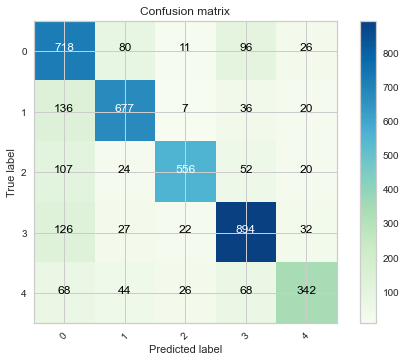

In [66]:
#Model fit on train and validate data
model_fit(dt,X_train, y_train, X_test, y_test,True)

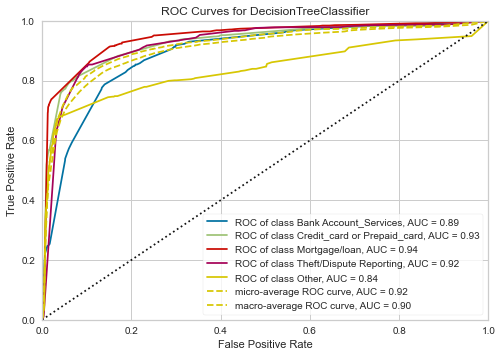

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Bank Account_Services', 1: 'Credit_card or Prepaid_card',
                2: 'Mortgage/loan', 3: 'Theft/Dispute Reporting', 4: 'Other'},
       estimator=DecisionTreeClassifier(max_depth=8, random_state=40))

In [67]:
#ROC curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
plot_ROC_curve(dt, X_train, y_train, X_test, y_test)

In [68]:
#Generating model report
cols = ['Model','ROC Score', 'Precision Score', 'Recall Score','Accuracy Score','Kappa Score']
models_report = pd.DataFrame(columns = cols)
from sklearn import metrics
tmp1 = pd.Series({'Model': " Decision Tree model",
                 'ROC Score' : metrics.roc_auc_score(y_test,dt.predict_proba(X_test),multi_class='ovo'),
                 'Precision Score': metrics.precision_score(y_test, dt.predict(X_test),average = 'macro'),
                 'Recall Score': metrics.recall_score(y_test,dt.predict(X_test),average = 'macro'),
                 'Accuracy Score': metrics.accuracy_score(y_test, dt.predict(X_test)),
                 'Kappa Score':metrics.cohen_kappa_score(y_test, dt.predict(X_test))})
model_1_report = models_report.append(tmp1, ignore_index = True)
model_1_report

C:\Users\44775\AppData\Local\Temp\ipykernel_20280\155815122.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,ROC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score
0,Decision Tree model,0.905444,0.773503,0.742533,0.756109,0.689825


## Model 2: Random Forest Classifier

In [69]:
# Using Random Forest Model :
rfc = RandomForestClassifier(random_state=40)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       931
           1       0.83      0.87      0.85       876
           2       0.90      0.86      0.88       759
           3       0.79      0.94      0.86      1101
           4       0.92      0.55      0.69       548

    accuracy                           0.83      4215
   macro avg       0.85      0.81      0.82      4215
weighted avg       0.84      0.83      0.83      4215

********************Confusion Matrix********************


C:\Users\44775\AppData\Local\Temp\ipykernel_20280\4125215162.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



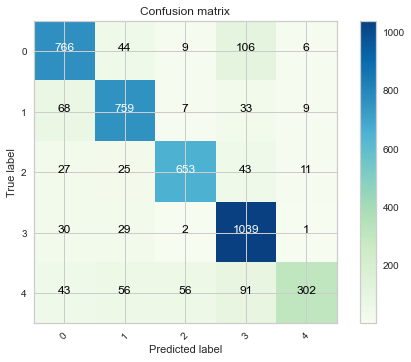

In [70]:
#Model fit on train and validate data
model_fit(rfc,X_train, y_train, X_test, y_test ,True)

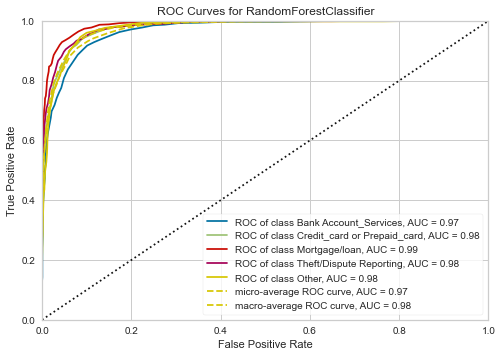

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Bank Account_Services', 1: 'Credit_card or Prepaid_card',
                2: 'Mortgage/loan', 3: 'Theft/Dispute Reporting', 4: 'Other'},
       estimator=RandomForestClassifier(random_state=40))

In [71]:
#ROC curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
plot_ROC_curve(rfc, X_train, y_train, X_test, y_test)

In [72]:
#Generating model report
cols = ['Model','ROC Score', 'Precision Score', 'Recall Score','Accuracy Score','Kappa Score']
models_report = pd.DataFrame(columns = cols)
from sklearn import metrics
tmp1 = pd.Series({'Model': "Random Forest Model",
                 'ROC Score' : metrics.roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovo'),
                 'Precision Score': metrics.precision_score(y_test, rfc.predict(X_test),average = 'macro'),
                 'Recall Score': metrics.recall_score(y_test,rfc.predict(X_test),average = 'macro'),
                 'Accuracy Score': metrics.accuracy_score(y_test, rfc.predict(X_test)),
                 'Kappa Score':metrics.cohen_kappa_score(y_test, rfc.predict(X_test))})
model_2_report = models_report.append(tmp1, ignore_index = True)
model_2_report

C:\Users\44775\AppData\Local\Temp\ipykernel_20280\1194026476.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,ROC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score
0,Random Forest Model,0.977468,0.851904,0.808867,0.834875,0.789254


## Model 3: Logistic Regression

In [73]:
# Logistic Regression
logreg = LogisticRegression(random_state = 42, max_iter=400)

********************Classification Report********************
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       931
           1       0.96      0.96      0.96       876
           2       0.97      0.96      0.96       759
           3       0.95      0.98      0.96      1101
           4       0.98      0.88      0.93       548

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215

********************Confusion Matrix********************


C:\Users\44775\AppData\Local\Temp\ipykernel_20280\4125215162.py:10: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



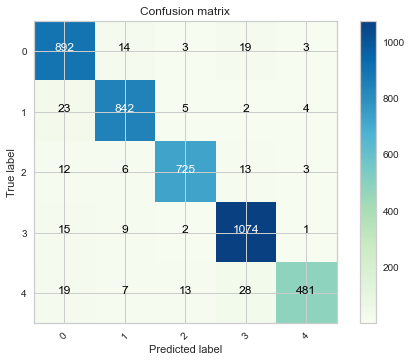

In [74]:
#Model fit on train and test data
model_fit(logreg,X_train, y_train, X_test, y_test ,True)

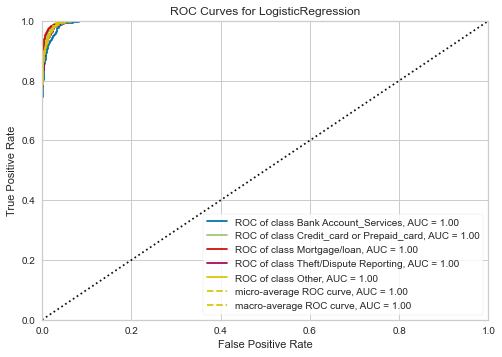

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'Bank Account_Services', 1: 'Credit_card or Prepaid_card',
                2: 'Mortgage/loan', 3: 'Theft/Dispute Reporting', 4: 'Other'},
       estimator=LogisticRegression(max_iter=400, random_state=42))

In [75]:
#ROC curve to inspect the tradeoff between sensitivity and specificity on a per-class basis
plot_ROC_curve(logreg, X_train, y_train, X_test, y_test)

In [76]:
#Generating model report
cols = ['Model','ROC Score', 'Precision Score', 'Recall Score','Accuracy Score','Kappa Score']
models_report = pd.DataFrame(columns = cols)
from sklearn import metrics
tmp1 = pd.Series({'Model': "Logistic Regression model",
                 'ROC Score' : metrics.roc_auc_score(y_test,logreg.predict_proba(X_test),multi_class='ovo'),
                 'Precision Score': metrics.precision_score(y_test, logreg.predict(X_test),average = 'macro'),
                 'Recall Score': metrics.recall_score(y_test,logreg.predict(X_test),average = 'macro'),
                 'Accuracy Score': metrics.accuracy_score(y_test, logreg.predict(X_test)),
                 'Kappa Score':metrics.cohen_kappa_score(y_test, logreg.predict(X_test))})
model_3_report = models_report.append(tmp1, ignore_index = True)
model_3_report

C:\Users\44775\AppData\Local\Temp\ipykernel_20280\4112102241.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Model,ROC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score
0,Logistic Regression model,0.997532,0.955903,0.945543,0.952313,0.939546


# Model Summary 

In [77]:
# Compare the result of the models.
Report_compare = pd.concat([model_1_report,model_2_report,model_3_report], axis=0,sort=False)
Report_compare=Report_compare.set_index('Model')
Report_compare


,ROC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score
Model,,,,,
Decision Tree model,0.905444,0.773503,0.742533,0.756109,0.689825
Random Forest Model,0.977468,0.851904,0.808867,0.834875,0.789254
Logistic Regression model,0.997532,0.955903,0.945543,0.952313,0.939546


### Based on the above result as well as comparing the ROC curve, we can see that the Logistic Regression model gives a good balance between Precision and Recall, better trade off between Sensitivity and Specificity. Even Logistic regression has better  Accuracy  and Kappa Scores than other models. Hence,Logistic Regression will be chosen for further inference.






# Model inference

In [85]:
#Custom text to predict the Topic

custom_text = 'Get a Loan on Credit Card from HDFC Bank in just three clicks! Digital portal: Click here to check your eligibility, choose the loan amount, and confirm 40 lakh + customers have availed a loan via our digital portal All you need is your mobile number and the last four digits of your Credit Card number NetBanking'

In [86]:
# transform using the existing count_vect

custom_text_count_vect= count_vect.transform([custom_text])

In [87]:
#transform using the existing tfidf_transformer

custom_text_transformed = tfidf_transformer.transform(custom_text_count_vect)

In [88]:
#Predicting the topic using logistic regression

custom_text_topic_prediction = logreg.predict(custom_text_transformed)

In [89]:
# Predicting the Model Class

Topic_names = {
    0: 'Bank_Account_Services',
    1: 'Credit_card or Prepaid_card',
    2: 'Mortgage/loan',
    3: 'Theft/Dispute Reporting',
    4: 'Others'   
}
print('Model Class is',Topic_names.get(int(custom_text_topic_prediction)))

Model Class is Mortgage/loan


In [90]:
#Probability of mapped topic names.

Topic_name_with_prob=pd.DataFrame(logreg.predict_proba(custom_text_transformed),columns=['Bank_account_services','Credit_card',
    'Mortgages/loans','Theft/Dispute reporting','Others']).rename(index={0: 'Probability'})
Topic_name_with_prob

,Bank_account_services,Credit_card,Mortgages/loans,Theft/Dispute reporting,Others
Probability,0.042848,0.391101,0.53108,0.021535,0.013436


## The model has predicted topic: `Mortgage/loan` with probability of 0.54
